### aim: 

### date: 

In [134]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [135]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [136]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

## definitions of equations for individual factors

In [137]:
def effect_SST(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area):
    
    dfco2 = mn_kg*0.04*mn_pCO2*sst_delta #dfCO2 = kg(4%-pCO2/degree x dSST)
    dfco2_pgCyr_SST = dfco2 * PgC_mol * SO_area #dfCO2 in PgC/yr

    return dfco2_pgCyr_SST

def effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area,\
                grad_dFedz, dmudFe, mu_L, diatconc, efratio):
    #dic
    dDIC = mld_delta*grad_dDICdz #dDIC = dMLD x dDIC/dz, umol/L
    dpCO2 = mn_Revfact * mn_pCO2 / mn_DIC * dDIC #dpCO2 = R x pCO2/DIC x dDIC, ppm
    dfCO2_DIC = mn_kg * dpCO2 #dfCO2_DIC = kg x dpCO2
    dfco2_pgCyr_MLD_DIC = dfCO2_DIC * PgC_mol * SO_area 

    ##ta
    dfcCO2_TA = (-1/3)*dfCO2_DIC
    dfco2_pgCyr_MLD_TA = dfcCO2_TA * PgC_mol * SO_area 

    #iron (ecosystem)
    dFe = mld_delta *  grad_dFedz #dFe = dMLD x dFe/dz 
    #print(dFe)
    dDIC_fe = -1 * dmudFe * dFe * mu_L * diatconc * 365.25 * efratio#dDIC = -dmu/dFe x dFe x mu_L x DIA x dtime  
    dpCO2_Fe = mn_Revfact * mn_pCO2 / mn_DIC * dDIC_fe  #dpCO2 = R x pCO2/DIC x dDIC
    #print(dpCO2_Fe)
    dfCO2_Fe = mn_kg * dpCO2_Fe
    #print(dfCO2_Fe)
    dfco2_pgCyr_MLD_Fe = dfCO2_Fe * PgC_mol * SO_area
    #print(dfco2_pgCyr_MLD_Fe)

    return dfco2_pgCyr_MLD_DIC, dfco2_pgCyr_MLD_TA, dfco2_pgCyr_MLD_Fe

def effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, diatconc, efratio):

    dfco2_pgCyr_OT_DIC = ot_delta * 1e6 * grad_DIC_surfdeep * 1000*31560000*0.000001*0.000000000000012 #dfCO2_DIC = dOverturning x (dDICv)
    dfco2_pgCyr_OT_TA = -(1/3)*dfco2_pgCyr_OT_DIC #dfCO2_TA = -1/3 x dfCO2_DIC
    #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    dDICv = -dmudFe* grad_dFev * mu_L * diatconc * 365.25 * efratio #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    dfco2_pgCyr_OT_Fe = dDICv * ot_delta * 1e6 * 1000*31560000*0.000001*0.000000000000012 # dfCO2_DIC = dOverturning x (dDIC)

    return dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe


def give_me_summary(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area,\
                    mld_delta, grad_dDICdz, mn_Revfact, mn_DIC, grad_dFedz, dmudFe, mu_L, diatconc,\
                    ot_delta,grad_DIC_surfdeep, grad_dFev, efratio, verbose = False): 

    dfco2_pgCyr_SST  = effect_SST(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area)

    dfco2_pgCyr_MLD_DIC, dfco2_pgCyr_MLD_TA, dfco2_pgCyr_MLD_Fe = \
        effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area, grad_dFedz, dmudFe, mu_L, diatconc, efratio)

    dfco2_pgCyr_OT_DIC, dfco2_pgCyr_OT_TA, dfco2_pgCyr_OT_Fe = \
        effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, diatconc, efratio)
    
    CO2_SST = dfco2_pgCyr_SST
    CO2_MLD_phys_chem = dfco2_pgCyr_MLD_TA + dfco2_pgCyr_MLD_DIC
    CO2_OT_phys_chem = dfco2_pgCyr_OT_TA + dfco2_pgCyr_OT_DIC
    CO2_OT_MLD_bio = dfco2_pgCyr_OT_Fe + dfco2_pgCyr_MLD_Fe
    CO2_tot = CO2_SST + CO2_MLD_phys_chem + CO2_OT_phys_chem + CO2_OT_MLD_bio
    if verbose:
        
        print('individual effects')
        print(f'effect SST pgC/yr {dfco2_pgCyr_SST}')
        print(f'effect MLD (TA, DIC, Fe) pgC/yr {dfco2_pgCyr_MLD_DIC}, {dfco2_pgCyr_MLD_TA}, {dfco2_pgCyr_MLD_Fe}')
        print(f'effect OT (TA, DIC, Fe) pgC/yr {dfco2_pgCyr_OT_DIC}, {dfco2_pgCyr_OT_TA}, {dfco2_pgCyr_OT_Fe}')

        print('')
        print('--summary (in PgC/yr)')
        print(f'Change in CO2 flux due to SST change {CO2_SST}')
        print(f'Change in CO2 flux due to MLD change (combined physico-chemical effects) {CO2_MLD_phys_chem}')
        print(f'Change in CO2 flux due to Overturning change (combined physico-chemical effects) {CO2_OT_phys_chem}')
        print(f'Change in CO2 flux due to MLD+Overturning change (ecosystem effects) {CO2_OT_MLD_bio}')
        print(f'Total change in CO2 flux {CO2_tot}')

    return CO2_SST, CO2_MLD_phys_chem, CO2_OT_phys_chem, dfco2_pgCyr_MLD_Fe, dfco2_pgCyr_OT_Fe, CO2_tot

#         dfco2_pgCyr_SST = effect_SST(mn_kg,mn_pCO2,sst_delta,PgC_mol,SO_area)
#         dfco2_pgCyr_MLD_DIC, dfco2_pgCyr_MLD_TA, dfco2_pgCyr_MLD_Fe = effect_MLD(mld_delta, grad_dDICdz, mn_Revfact, mn_pCO2, mn_DIC, mn_kg, PgC_mol, SO_area)



def make_BOE_output(changes_str, input_str, output_str, verbose = False):
    
    changes = xr.open_dataset(changes_str)
    inputs = xr.open_dataset(input_str)
    savenam = output_str
    print(f'making {savenam}')
    
    datar = np.zeros([3,5,6,2,2])
    sigar = np.zeros([3,5,6,2,2])
    data_vars = {'trend':(['period', 'season', 'quantity', 'forcing','scenario'], datar,
    {'units': '/yr',
    'long_name':''}),
                 'sig':(['period', 'season', 'quantity', 'forcing','scenario'], sigar,
    {'units': '/yr',
    'long_name':''}),
    }
    # define coordinates
    coords = {'period': (['period'], ['1950-2000','2000-2050','2050-2100']),
              'season': (['season'], ['FY','DJF','MAM','JJA','SON']),
              'quantity': (['quantity'], ['CO2_SST','CO2_MLD_phys_chem',\
                                          'CO2_OT_phys_chem','CO2_MLD_bio',\
                                          'CO2_OT_bio','CO2_tot']),
              'forcing': (['forcing'], ['ghg','ozone']),
              'scenario': (['scenario'], ['ssp1','ssp3']),

             }
    attrs = {'made in':'scratch/BOE-SOcarbon/sketch-refactor.ipynb',
    'desc': 'yearly medusa files, saving only variables of interest'
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)

    ###constants
    efratio = 0.5
    PgC_mol = 1.2e-14 # pgC/mol
    SO_area = 5.94e13 # assuming 1/6 of the global ocean south of 50S, calculate this from mesh mask

    periodar =  ['1950-2000','2000-2050','2050-2100']
    seasonar = ['FY','DJF','MAM','JJA','SON']
    forcingar = ['ghg','ozone']
    scenarioar = ['ssp1','ssp3']

    for p in periodar:
        tpe = int(p[0:4])
        for s in seasonar:
            for f in forcingar:
                for sc in scenarioar:

                    sst_t = changes.trend.loc[{'period':p, 'season':s, 'quantity': 'sst', \
                      'forcing': f, 'scenario': sc }].values *5 # / decade to / 50 yrs  
                    mld_t = changes.trend.loc[{'period':p, 'season':s, 'quantity': 'mld', \
                      'forcing': f, 'scenario': sc }].values*5  # / decade to / 50 yrs  
                    ot_t = changes.trend.loc[{'period':p, 'season':s, 'quantity': 'ot', \
                      'forcing': f, 'scenario': sc }].values *5 # / decade to / 50 yrs  

                    sst_sig = changes.sig.loc[{'period':p, 'season':s, 'quantity': 'sst', \
                      'forcing': f, 'scenario': sc }].values # / decade to / 50 yrs  
                    mld_sig = changes.sig.loc[{'period':p, 'season':s, 'quantity': 'mld', \
                      'forcing': f, 'scenario': sc }].values  # / decade to / 50 yrs  
                    ot_sig = changes.sig.loc[{'period':p, 'season':s, 'quantity': 'ot', \
                      'forcing': f, 'scenario': sc }].values  # / decade to / 50 yrs  


                    if verbose:
                        print(f'{p} (starts {tpe}), {s}, {f}, {sc}')
                        print(f'---temp delta {sst_t}, mld delta {mld_t}, ot delta {ot_t}')
                        print(f'---temp sig {sst_sig}, mld sig {mld_sig}, ot sig {ot_sig}')

                    mn_kg = inputs.mn_kg.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    mn_pCO2 = inputs.mn_pCO2.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    grad_dDICdz = inputs.grad_dDICdz.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    mn_Revfact = inputs.mn_Revfact.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    grad_DIC_surfdeep = inputs.grad_DIC_surfdeep.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    diatconc = inputs.diatconc.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    grad_dFedz = inputs.grad_dFedz.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    grad_dFev = inputs.grad_dFev.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    dmudFe = inputs.dmudFe.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    mn_DIC = inputs.mn_DIC.loc[{'period':p, 'season':s, 'scenario': sc }].values 
                    mu_L = inputs.mu_L.loc[{'period':p, 'season':s, 'scenario': sc }].values 


                    CO2_SST, CO2_MLD_phys_chem, CO2_OT_phys_chem,\
                    dfco2_pgCyr_MLD_Fe, dfco2_pgCyr_OT_Fe, CO2_tot =\
                    give_me_summary(mn_kg,mn_pCO2,sst_t,PgC_mol,SO_area,\
                    mld_t, grad_dDICdz, mn_Revfact, mn_DIC, grad_dFedz, dmudFe, mu_L, diatconc,\
                    ot_t,grad_DIC_surfdeep, grad_dFev, efratio, verbose = verbose)


                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                      'forcing': f, 'scenario': sc }] = CO2_SST
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                      'forcing': f, 'scenario': sc }] = CO2_OT_phys_chem
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                      'forcing': f, 'scenario': sc }] = CO2_MLD_phys_chem
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                      'forcing': f, 'scenario': sc }] = dfco2_pgCyr_MLD_Fe
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                      'forcing': f, 'scenario': sc }] = dfco2_pgCyr_OT_Fe
                    ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                      'forcing': f, 'scenario': sc }] = CO2_tot

                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                      'forcing': f, 'scenario': sc }] = sst_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                      'forcing': f, 'scenario': sc }] = ot_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                      'forcing': f, 'scenario': sc }] = mld_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                      'forcing': f, 'scenario': sc }] = mld_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                      'forcing': f, 'scenario': sc }] = ot_sig
                    ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                      'forcing': f, 'scenario': sc }] = np.min([sst_sig,ot_sig,mld_sig])


            if verbose:
                print()
                print()

    ds.to_netcdf(savenam)
    print('done calculations')
    
    return ds


## calculate summary for a netcdf of changes and parameter inputs

In [138]:
verbose = False
changes_str = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/extracted-summary/all-medusa-50yrtrends.nc'
input_str = './data/BOE-INPUT-CLQdummy.nc'
output_str = './data/BOE-OUTPUT-CLQdummy.nc'
pipstvo = make_BOE_output(changes_str, input_str, output_str, verbose = verbose)

verbose = False
changes_str = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/extracted-summary/all-medusa-50yrtrends.nc'
input_str = './data/BOE-INPUT-medusamodel.nc'
output_str = './data/BOE-OUTPUT-medusamodel.nc'
pipstvo = make_BOE_output(changes_str, input_str, output_str, verbose = verbose)


making ./data/BOE-OUTPUT-CLQdummy.nc
done calculations
making ./data/BOE-OUTPUT-medusamodel.nc
done calculations


### code to make graphs

In [163]:

def make_boe_summary_graph_both_ssps(output_str, fnam_str, valuedesc = ''):
    
    ds = xr.open_dataset(output_str)
    #### ssps 1 and 3 figure
    fact = 1.1
    fig, axs = plt.subplots(5,3, figsize=(15*fact, 12*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    tw = 0.4; lowsigalpha = 0.25; tlw = 1.5; lowsiglw = 0
    
    seasonar = ['FY','FY','FY',\
                'DJF','DJF','DJF',\
                'MAM', 'MAM', 'MAM',\
                'JJA','JJA','JJA',\
                'SON','SON','SON']
    periodar = ['1950-2000','2000-2050','2050-2100']
    for i in range(0,15):

        per = i%3
        p = periodar[per]
        s = seasonar[i]
        fs = ['ghg','ghg','ozone','ozone'];
        scs = ['ssp1','ssp3','ssp1','ssp3']
        inds = [0.45,2.95,5.45,7.95]
        for x in range(4):
            
            f = fs[x]; sc = scs[x]; ind = inds[x]
            
            CO2_SST = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            ##### significances
            CO2_SST_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            CO2_SST_alpha = 1; CO2_OT_phys_chem_alpha = 1
            CO2_MLD_phys_chem_alpha = 1; CO2_MLD_bio_alpha = 1
            CO2_OT_bio_alpha = 1; CO2_tot_alpha = 1; CO2_bio_alpha = 1
            
            CO2_SST_lw = tlw; CO2_OT_phys_chem_lw = tlw
            CO2_MLD_phys_chem_lw = tlw; CO2_MLD_bio_lw = tlw
            CO2_OT_bio_lw = tlw; CO2_tot_lw = tlw; CO2_bio_lw = tlw
            
            
            if CO2_SST_sig == 0: CO2_SST_alpha = lowsigalpha
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_alpha = lowsigalpha
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_alpha = lowsigalpha
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_alpha = lowsigalpha
            if CO2_OT_bio_sig == 0: CO2_OT_bio_alpha = lowsigalpha
            if CO2_tot_sig == 0: CO2_tot_alpha = lowsigalpha
                
            if CO2_SST_sig == 0: CO2_SST_lw = lowsiglw
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_lw = lowsiglw
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_lw = lowsiglw
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_lw = lowsiglw
            if CO2_OT_bio_sig == 0: CO2_OT_bio_lw = lowsiglw
            if CO2_tot_sig == 0: CO2_tot_lw = lowsiglw
            
            ms = 7
            if ind == inds[0]:
                axs[i].bar(ind,CO2_tot,width = tw, color = 'k', alpha = CO2_tot_alpha,\
                           edgecolor = 'k', lw = CO2_tot_lw, label = 'Total $\Delta$ CO2flux')
                
                axs[i].bar(ind+tw*2,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                            edgecolor = 'k', lw = CO2_SST_lw, label = '$\Delta$ CO2flux due to $\Delta$ SST')
                
                axs[i].bar(ind+tw,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                        edgecolor = 'k', lw = CO2_OT_phys_chem_lw, 
                        label = '$\Delta$ CO2flux due to $\Delta$ OT \n (combined phys.-chem. effects)') 
                
                axs[i].bar(ind+tw*3,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha, \
                        edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,
                        label = '$\Delta$ CO2flux due to $\Delta$ MLD \n (combined phys.-chem. effects)')   
                
                axs[i].bar(ind+tw*4,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha, \
                        edgecolor = 'k', lw = CO2_bio_lw,
                        label = '$\Delta$ CO2flux due to \n $\Delta$MLD+$\Delta$OT change \n (ecosystem effects)')  
                
                axs[i].axvline(x = 5, linestyle = ':', linewidth = tw)

            else:
                axs[i].bar(ind,CO2_tot,width = tw, color = 'k', alpha = CO2_tot_alpha,\
                          edgecolor = 'k', lw = CO2_tot_lw)
                
                axs[i].bar(ind+tw*2,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                          edgecolor = 'k', lw = CO2_SST_lw)
                
                axs[i].bar(ind+tw,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_OT_phys_chem_lw, )
                
                axs[i].bar(ind+tw*3,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,)
                
                axs[i].bar(ind+tw*4,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha,\
                          edgecolor = 'k', lw = CO2_bio_lw,)  
                
                axs[i].axvline(x = 5, linestyle = ':', linewidth = tw)
                axs[i].axvline(x = 5, linestyle = '-', linewidth = 2, color = 'grey')
                axs[i].axvline(x = 2.5, linestyle = ':', linewidth = 0.9, color = 'grey')
                axs[i].axvline(x = 7.5, linestyle = ':', linewidth = 0.9, color = 'grey')

    

        axs[i].set_xticks([1.25,3.75,6.25,8.75])
        axs[i].set_xlim([0,10])
        axs[i].set_xticklabels(['ghg ef. \n ssp1','ghg ef. \n ssp3','ozone \n ef. ssp1','ozone \n ef. ssp3'])
        axs[i].set_title(f'{p} {s}')
        axs[0].set_ylabel('pgC')
        axs[i].axhline(y=0, color = 'k')
        
    axs[2].legend(bbox_to_anchor = [1,1], fontsize = 10)
    plt.suptitle(f'Relative climate-driven contributions to CO2 flux, \n SSP1-2.6 and SSP3-7.0, data source = {valuedesc}')

    plt.tight_layout()
    print(f'saved figure at {fnam_str}')
    plt.savefig(fnam_str)

In [165]:

def make_boe_summary_graph_one_ssp(output_str, fnam_str, tssp, valuedesc = ''):
    
    ds = xr.open_dataset(output_str)
    #### ssps 1 and 3 figure
    fact = 1.1
    fig, axs = plt.subplots(5,3, figsize=(10*fact, 12*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    tw = 0.4; lowsigalpha = 0.25; tlw = 1.5; lowsiglw = 0
    
    seasonar = ['FY','FY','FY',\
                'DJF','DJF','DJF',\
                'MAM', 'MAM', 'MAM',\
                'JJA','JJA','JJA',\
                'SON','SON','SON']
    periodar = ['1950-2000','2000-2050','2050-2100']
    for i in range(0,15):

        per = i%3
        p = periodar[per]
        s = seasonar[i]
        fs = ['ghg','ozone',];
        scs = [tssp,tssp]
        inds = [0.45,2.95,5.45,7.95]
        for x in range(2):
            
            f = fs[x]; sc = scs[x]; ind = inds[x]
            
            CO2_SST = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot = ds.trend.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            ##### significances
            CO2_SST_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_SST', \
                          'forcing': f, 'scenario': sc }]

            CO2_OT_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_phys_chem_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_phys_chem', \
                          'forcing': f, 'scenario': sc }] 

            CO2_MLD_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_MLD_bio', \
                          'forcing': f, 'scenario': sc }] 

            CO2_OT_bio_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_OT_bio', \
                          'forcing': f, 'scenario': sc }]

            CO2_tot_sig = ds.sig.loc[{'period':p, 'season':s, 'quantity': 'CO2_tot', \
                          'forcing': f, 'scenario': sc }] 
            
            CO2_SST_alpha = 1; CO2_OT_phys_chem_alpha = 1
            CO2_MLD_phys_chem_alpha = 1; CO2_MLD_bio_alpha = 1
            CO2_OT_bio_alpha = 1; CO2_tot_alpha = 1; CO2_bio_alpha = 1
            
            CO2_SST_lw = tlw; CO2_OT_phys_chem_lw = tlw
            CO2_MLD_phys_chem_lw = tlw; CO2_MLD_bio_lw = tlw
            CO2_OT_bio_lw = tlw; CO2_tot_lw = tlw; CO2_bio_lw = tlw
            
            
            if CO2_SST_sig == 0: CO2_SST_alpha = lowsigalpha
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_alpha = lowsigalpha
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_alpha = lowsigalpha
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_alpha = lowsigalpha
            if CO2_OT_bio_sig == 0: CO2_OT_bio_alpha = lowsigalpha
            if CO2_tot_sig == 0: CO2_tot_alpha = lowsigalpha
                
            if CO2_SST_sig == 0: CO2_SST_lw = lowsiglw
            if CO2_OT_phys_chem_sig == 0: CO2_OT_phys_chem_lw = lowsiglw
            if CO2_MLD_phys_chem_sig == 0: CO2_MLD_phys_chem_lw = lowsiglw
            if ((CO2_MLD_bio_sig == 0) | (CO2_OT_bio_sig == 0)) : CO2_bio_lw = lowsiglw
            if CO2_OT_bio_sig == 0: CO2_OT_bio_lw = lowsiglw
            if CO2_tot_sig == 0: CO2_tot_lw = lowsiglw
            
            ms = 7
            if ind == inds[0]:
                axs[i].bar(ind,CO2_tot,width = tw, color = 'k', alpha = CO2_tot_alpha,\
                           edgecolor = 'k', lw = CO2_tot_lw, label = 'Total $\Delta$ CO2flux')
                
                axs[i].bar(ind+tw*2,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                            edgecolor = 'k', lw = CO2_SST_lw, label = '$\Delta$ CO2flux due to $\Delta$ SST')
                
                axs[i].bar(ind+tw,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                        edgecolor = 'k', lw = CO2_OT_phys_chem_lw, 
                        label = '$\Delta$ CO2flux due to $\Delta$ OT \n (combined phys.-chem. effects)') 
                
                axs[i].bar(ind+tw*3,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha, \
                        edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,
                        label = '$\Delta$ CO2flux due to $\Delta$ MLD \n (combined phys.-chem. effects)')   
                
                axs[i].bar(ind+tw*4,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha, \
                        edgecolor = 'k', lw = CO2_bio_lw,
                        label = '$\Delta$ CO2flux due to \n $\Delta$MLD+$\Delta$OT change \n (ecosystem effects)')  
                
                axs[i].axvline(x = 5, linestyle = ':', linewidth = tw)

            else:
                axs[i].bar(ind,CO2_tot,width = tw, color = 'k', alpha = CO2_tot_alpha,\
                          edgecolor = 'k', lw = CO2_tot_lw)
                
                axs[i].bar(ind+tw*2,CO2_SST,width = tw, color = 'b', alpha = CO2_SST_alpha,\
                          edgecolor = 'k', lw = CO2_SST_lw)
                
                axs[i].bar(ind+tw,CO2_OT_phys_chem,width = tw, color = 'r', alpha = CO2_OT_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_OT_phys_chem_lw, )
                
                axs[i].bar(ind+tw*3,CO2_MLD_phys_chem,width = tw, color = 'y', alpha = CO2_MLD_phys_chem_alpha,\
                          edgecolor = 'k', lw = CO2_MLD_phys_chem_lw,)
                
                axs[i].bar(ind+tw*4,CO2_MLD_bio+CO2_OT_bio,width = tw, color = 'green', alpha = CO2_bio_alpha,\
                          edgecolor = 'k', lw = CO2_bio_lw,)  
                
                axs[i].axvline(x = 5, linestyle = ':', linewidth = tw)
                axs[i].axvline(x = 5, linestyle = '-', linewidth = 2, color = 'grey')
                axs[i].axvline(x = 2.5, linestyle = ':', linewidth = 0.9, color = 'grey')
                axs[i].axvline(x = 7.5, linestyle = ':', linewidth = 0.9, color = 'grey')

    

        axs[i].set_xticks([1.25,3.75])
        axs[i].set_xlim([0,5])
        axs[i].set_xticklabels(['ghg \n effect','ozone \n effect'])
        axs[i].set_title(f'{p} {s}')
        axs[0].set_ylabel('pgC')
        axs[i].axhline(y=0, color = 'k')
        
    axs[2].legend(bbox_to_anchor = [1,0.95], fontsize = 10)
    plt.suptitle(f'Relative climate-driven contributions to CO2 flux, \n {tssp}, data source = {valuedesc}')
    plt.tight_layout()
    print(f'saved figure at {fnam_str}')
    plt.savefig(fnam_str)
    



saved figure at ./figs/BOE-FIG-ssp1-CLQdummy.jpg
saved figure at ./figs/BOE-FIG-ssp3-CLQdummy.jpg
saved figure at ./figs/BOE-FIG-bothssp-CLQdummy.jpg
saved figure at ./figs/BOE-FIG-ssp1-medusamodel.jpg
saved figure at ./figs/BOE-FIG-ssp3-medusamodel.jpg
saved figure at ./figs/BOE-FIG-bothssp-medusamodel.jpg


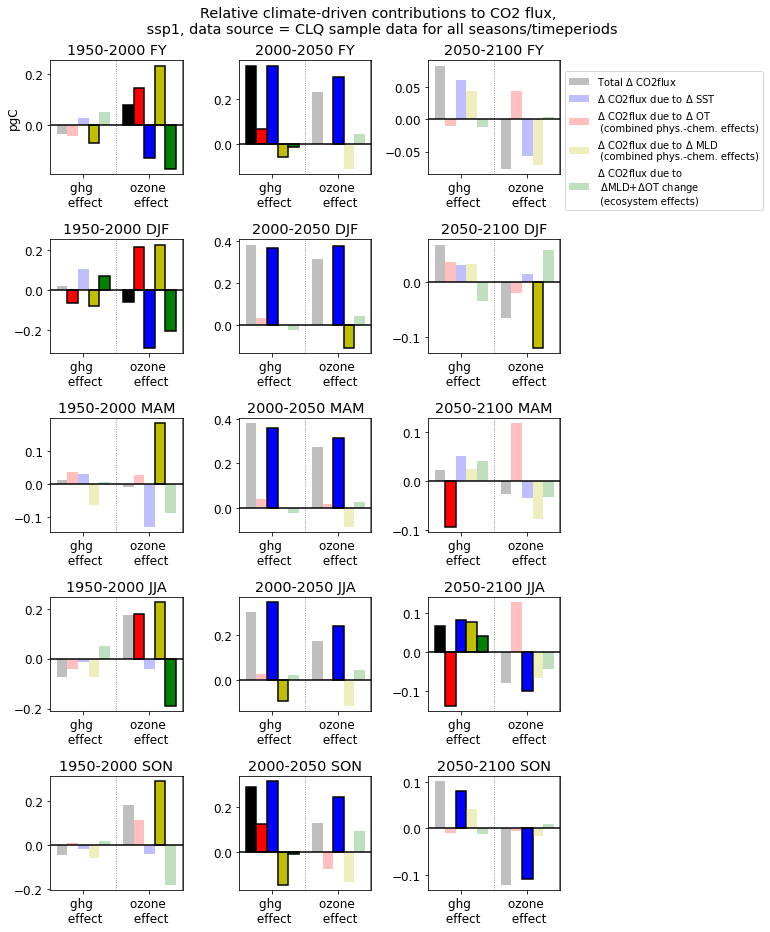

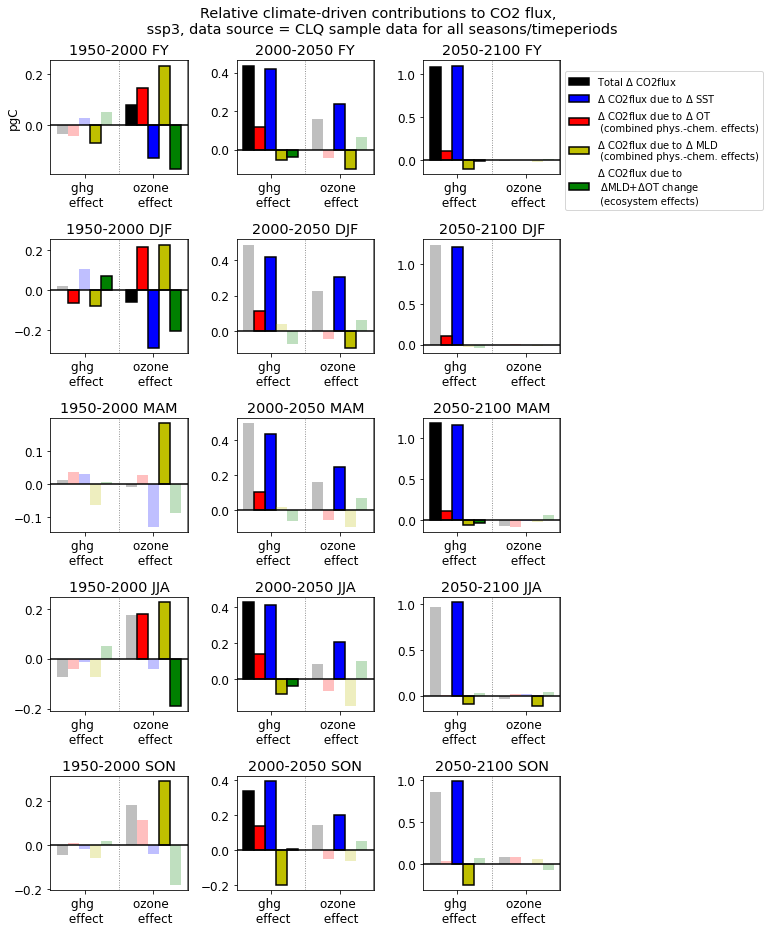

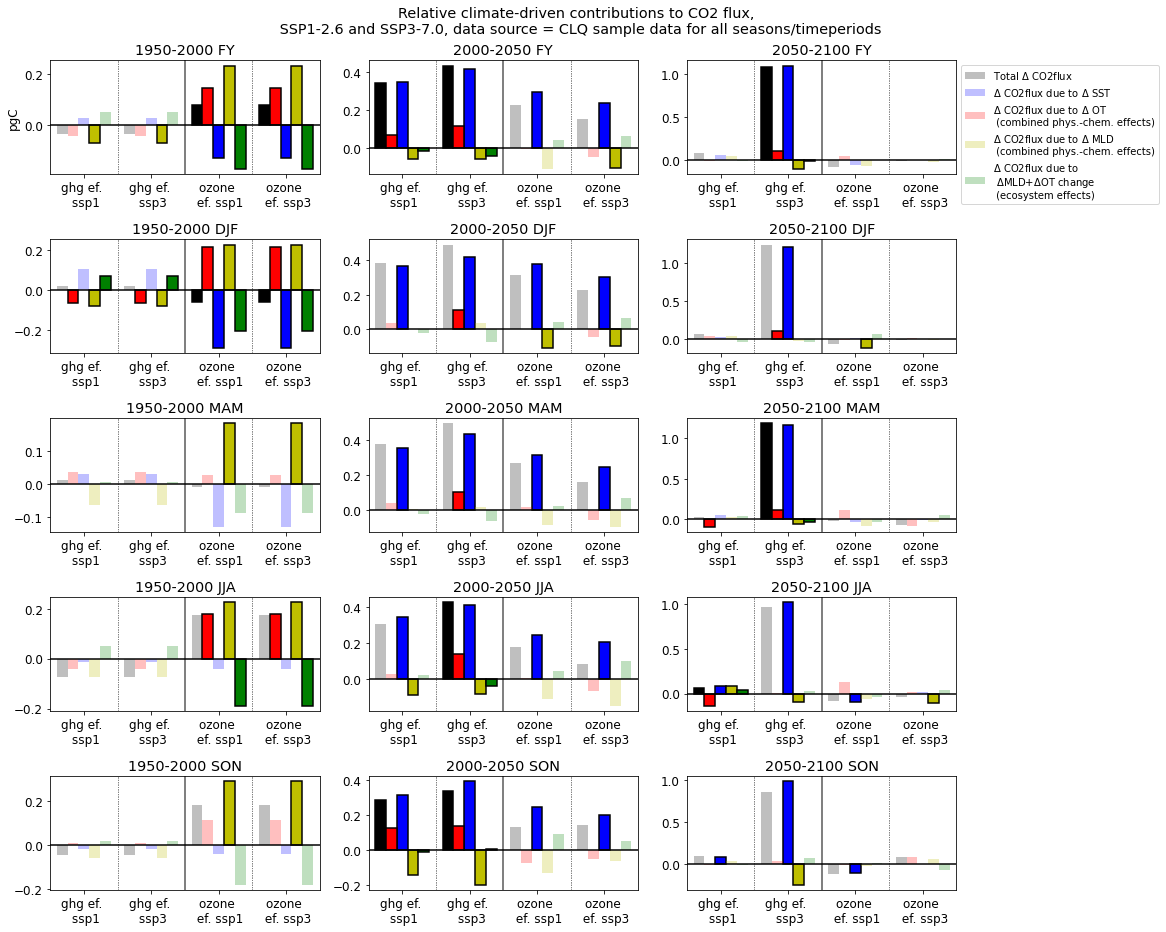

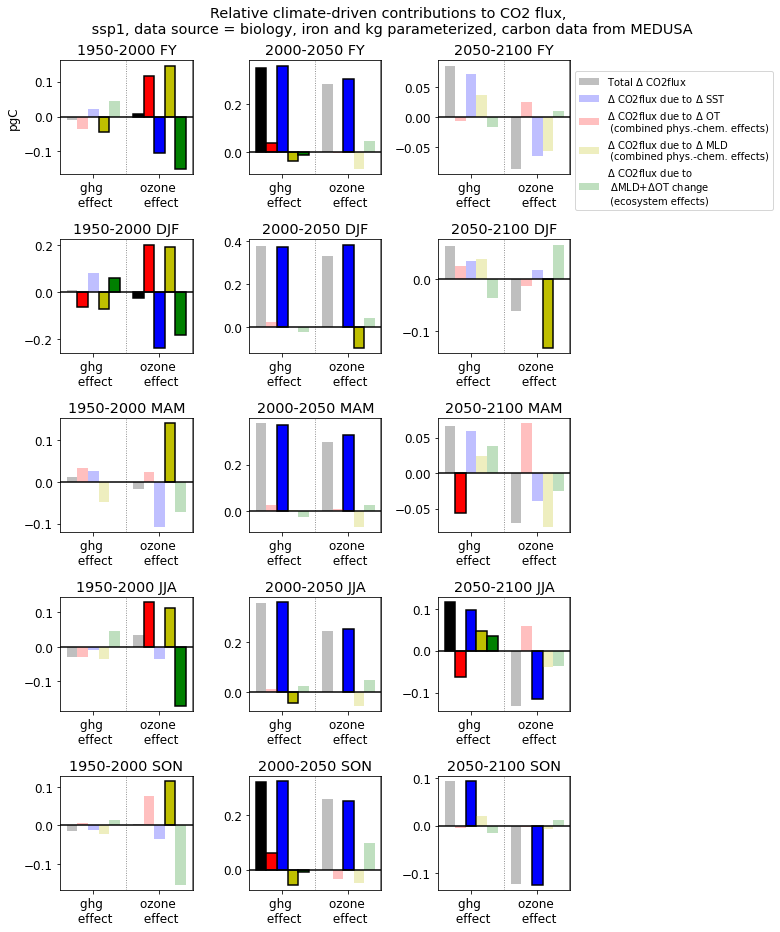

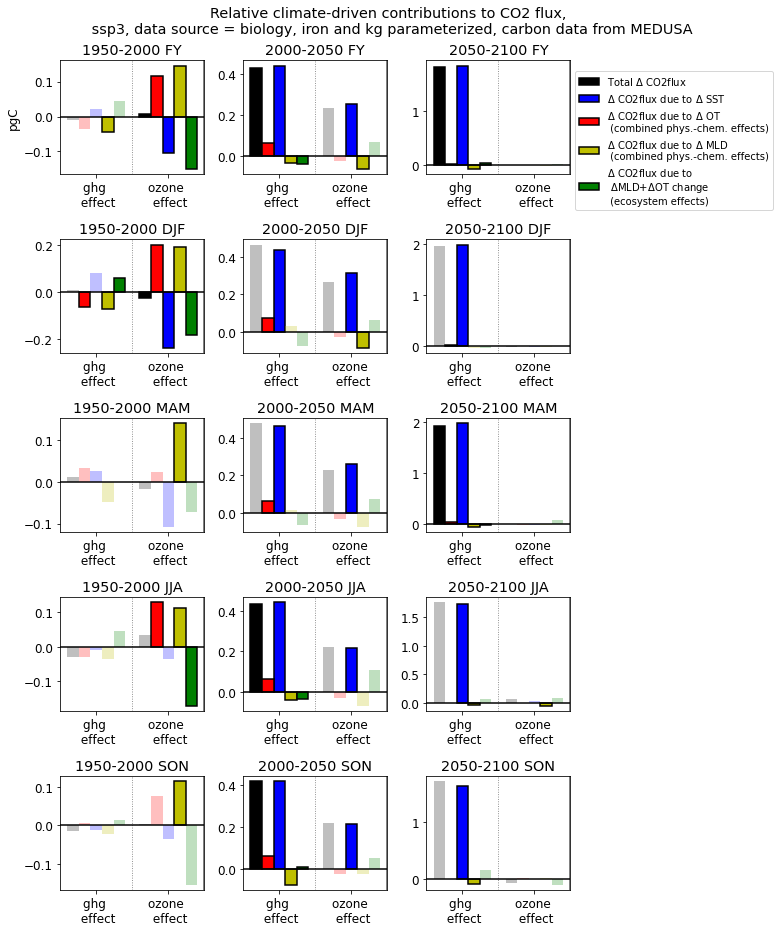

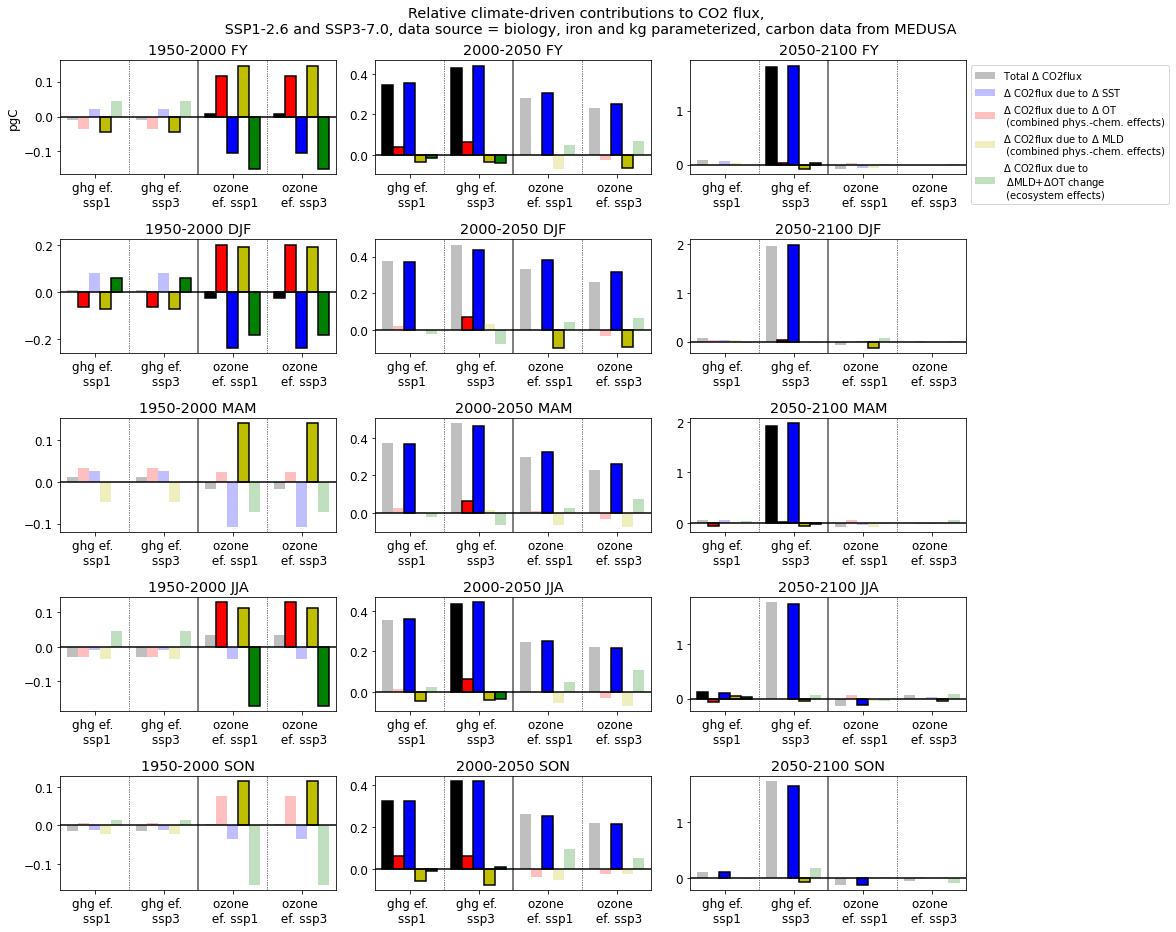

In [166]:
output_str = './data/BOE-OUTPUT-CLQdummy.nc'
valuedesc = 'CLQ sample data for all seasons/timeperiods'

tssp = 'ssp1'; 
fnam_str = f'./figs/BOE-FIG-{tssp}-CLQdummy.jpg'
make_boe_summary_graph_one_ssp(output_str, fnam_str, tssp, valuedesc)

tssp = 'ssp3'; 
fnam_str = f'./figs/BOE-FIG-{tssp}-CLQdummy.jpg'
make_boe_summary_graph_one_ssp(output_str, fnam_str, tssp, valuedesc)

fnam_str = f'./figs/BOE-FIG-bothssp-CLQdummy.jpg'
make_boe_summary_graph_both_ssps(output_str, fnam_str, valuedesc)

######

output_str = './data/BOE-OUTPUT-medusamodel.nc'
valuedesc = 'biology, iron and kg parameterized, carbon data from MEDUSA'

tssp = 'ssp1'; 
fnam_str = f'./figs/BOE-FIG-{tssp}-medusamodel.jpg'
make_boe_summary_graph_one_ssp(output_str, fnam_str, tssp, valuedesc)

tssp = 'ssp3'; 
fnam_str = f'./figs/BOE-FIG-{tssp}-medusamodel.jpg'
make_boe_summary_graph_one_ssp(output_str, fnam_str, tssp, valuedesc)

fnam_str = f'./figs/BOE-FIG-bothssp-medusamodel.jpg'
make_boe_summary_graph_both_ssps(output_str, fnam_str, valuedesc)

saved figure at ./figs/BOE-FIG-bothssp-medusamodel.jpg


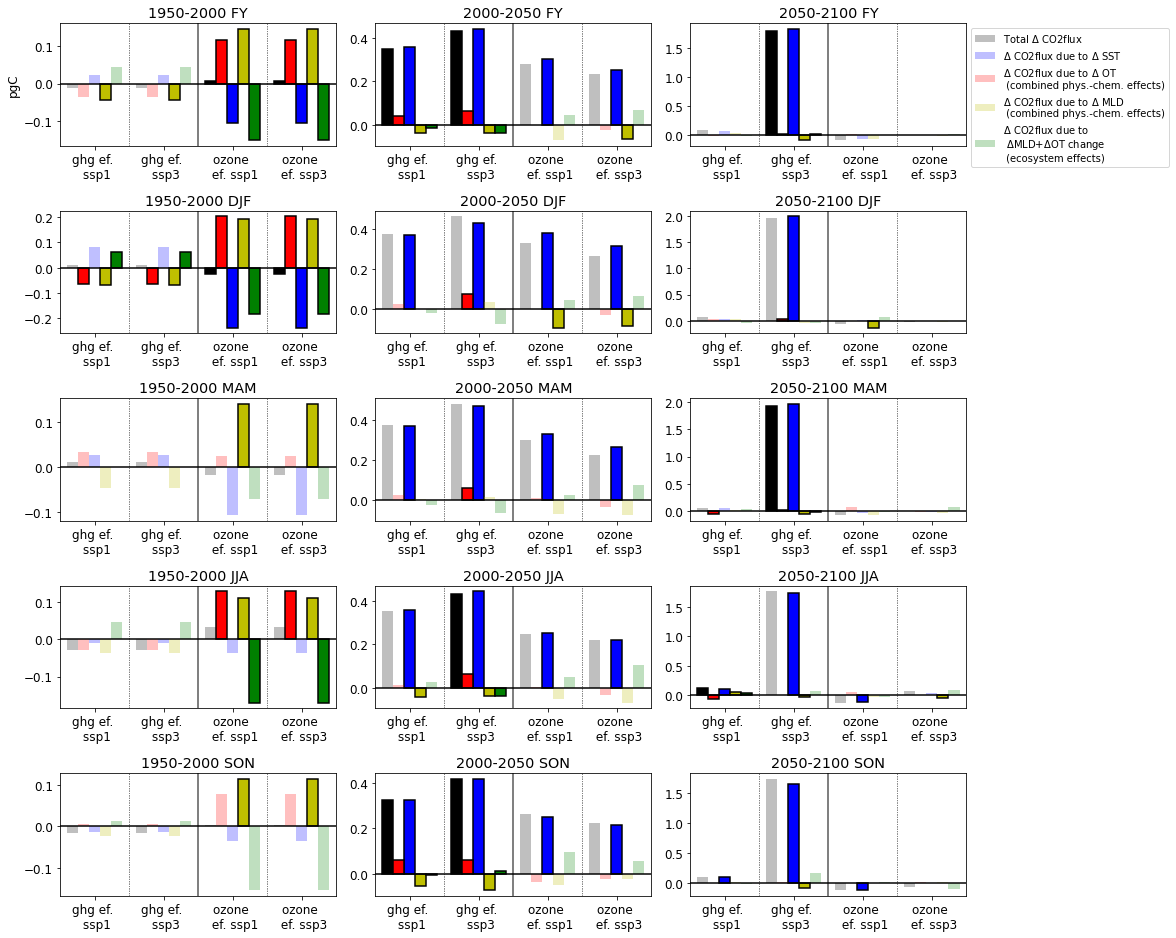

In [141]:
output_str = './data/BOE-OUTPUT-medusamodel.nc'
fnam_str = './figs/BOE-FIG-bothssp-medusamodel.jpg'
make_boe_summary_graph_both_ssps(output_str, fnam_str)